In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import logging
logging.getLogger('fbprophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv('../examples/example_wp_log_peyton_manning.csv')
df = df.loc[:180,]  # Limit to first six months
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=60)

In [2]:
%%R
library(prophet)
df <- read.csv('../examples/example_wp_log_peyton_manning.csv')
df <- df[1:180,]
m <- prophet(df)
future <- make_future_dataframe(m, periods=60)

Initial log joint probability = -2.43365
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


By default Prophet will return uncertainty intervals for the forecast `yhat`. There are several important assumptions behind these uncertainty intervals.

There are three sources of uncertainty in the forecast: uncertainty in the trend, uncertainty in the seasonality estimates, and additional observation noise.

### Uncertainty in the trend
The biggest source of uncertainty in the forecast is the potential for future trend changes. The time series we have seen already in this documentation show clear trend changes in the history. Prophet is able to detect and fit these, but what trend changes should we expect moving forward? It's impossible to know for sure, so we do the most reasonable thing we can, and we assume that the *future will see similar trend changes as the history*. In particular, we assume that the average frequency and magnitude of trend changes in the future will be the same as that which we observe in the history. We project these trend changes forward and by computing their distribution we obtain uncertainty intervals.

One property of this way of measuring uncertainty is that allowing higher flexibility in the rate, by increasing `changepoint_prior_scale`, will increase the forecast uncertainty. This is because if we model more rate changes in the history then we will expect more in the future, and makes the uncertainty intervals a useful indicator of overfitting.

The width of the uncertainty intervals (by default 80%) can be set using the parameter `interval_width`:

In [3]:
%%R
m <- prophet(df, interval.width = 0.95)
forecast <- predict(m, future)

Initial log joint probability = -2.43365
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [4]:
forecast = Prophet(interval_width=0.95).fit(df).predict(future)

Again, these intervals assume that the future will see the same frequency and magnitude of rate changes as the past. This assumption is probably not true, so you should not expect to get accurate coverage on these uncertainty intervals.

### Uncertainty in seasonality
By default Prophet will only return uncertainty in the trend and observation noise. To get uncertainty in seasonality, you must do full Bayesian sampling. This is done using the parameter `mcmc.samples` (which defaults to 0). We do this here for the first six months of the Peyton Manning data from the Quickstart:

In [5]:
%%R
m <- prophet(df, mcmc.samples = 300)
forecast <- predict(m, future)


SAMPLING FOR MODEL 'prophet' NOW (CHAIN 1).

Gradient evaluation took 5.3e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.53 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 120 / 300 [ 40%]  (Warmup)
Iteration: 150 / 300 [ 50%]  (Warmup)
Iteration: 151 / 300 [ 50%]  (Sampling)
Iteration: 180 / 300 [ 60%]  (Sampling)
Iteration: 210 / 300 [ 70%]  (Sampling)
Iteration: 240 / 300 [ 80%]  (Sampling)
Iteration: 270 / 300 [ 90%]  (Sampling)
Iteration: 300 / 300 [100%]  (Sampling)

 Elapsed Time: 1.61713 seconds (Warm-up)
               1.46049 seconds (Sampling)
               3.07762 seconds (Total)


SAMPLING FOR MODEL 'prophet' NOW (CHAIN 2).

Gradient evaluation took 4.9e-05 seconds
1000 transitions using 10 leapfrog steps per transition would take 0.49 seconds.
Adjust your expectations accordi

In [6]:
m = Prophet(mcmc_samples=300)
forecast = m.fit(df).predict(future)

This replaces the typical MAP estimation with MCMC sampling, and can take much longer depending on how many observations there are - expect several minutes instead of several seconds. If you do full sampling, then you will see the uncertainty in seasonal components when you plot them:

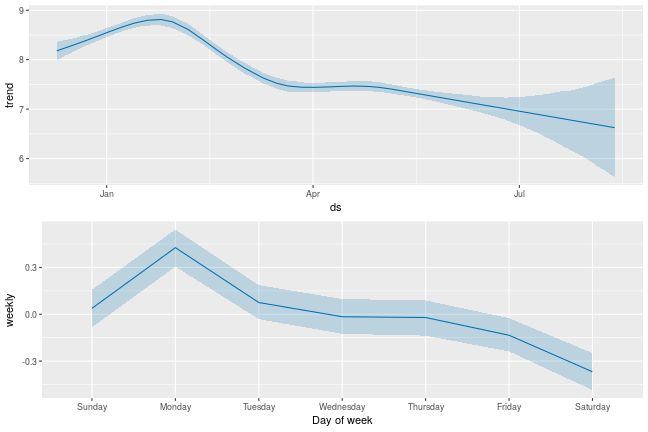

In [7]:
%%R -w 9 -h 6 -u in
prophet_plot_components(m, forecast)

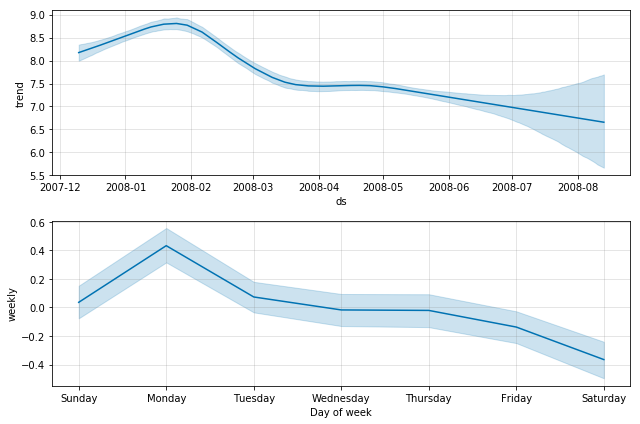

In [8]:
fig = m.plot_components(forecast)

You can access the raw posterior predictive samples in Python using the method `m.predictive_samples(future)`, or in R using the function `predictive_samples(m, future)`.

There are upstream issues in PyStan for Windows which make MCMC sampling extremely slow. The best choice for MCMC sampling in Windows is to use R, or Python in a Linux VM.